In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pyspark

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import StratifiedKFold

% matplotlib inline

In [2]:
from pyspark.mllib.recommendation import ALS
import math

In [3]:
home = "/Users/Alexander/WINE/data/"
pseudo_ratings_path = home + "ratings_df.pkl"
wine_path = home + "wine_df_red_white_only.pkl"

In [4]:
rating_df = pd.read_pickle(pseudo_ratings_path)

#### Get Subsample of Data
    Spark keeps crashing when using full data set
    Perhaps running Sparking on AWS cluster will help
    Error results get a lot better with large data size

In [5]:
# Spark keeps crashing when using full data set
# Perhaps running Sparking on AWS cluster will help
rating_df = rating_df.sample(n = 200000)

In [6]:
# number of nodes in local spark cluster
n_nodes = 3
sc = pyspark.SparkContext(master = "local[{}]".format(n_nodes))

In [7]:
def transform_data(rating_df):
    def get_df_values_by_col(df):
        cust_tags = df.CustomerHash.values
        wine_productKeys = df.ProductKey.values
        ratings = df.Ratings.values
        return cust_tags, wine_productKeys, ratings

    def create_userHash_userid_pairs(cust_tags):
        # create int:cust_tag key value pairs
        # spark can't read string user ids
        index_to_int = np.arange(0, len(cust_tags) * 100, 100)
        return  index_to_int, [ [tag_int, tag_hash] for tag_hash, tag_int in zip(cust_tags, index_to_int)]

    # move customerHashs, productKeys,and ratings each to their own list
    cust_tags, wine_productKeys, ratings = get_df_values_by_col(rating_df)

    # generate a numeric index for each customerHash
    index_to_int, cust_tag_bridge = create_userHash_userid_pairs(cust_tags)
    
    # move data from df to list
    complete_data = rating_df.values.tolist()
    # move data to rdd
    complete_data_rdd = sc.parallelize(complete_data)
    # formate rdd
    complete_data_rdd = complete_data_rdd.map(lambda row: (row[0], (row[1], row[2])) )
    # move customerHash, customer numeric key/value pairs to rdd
    cust_tag_bridge_rdd = sc.parallelize(cust_tag_bridge)
    # formate customer hash/numeric rdd
    cust_tag_bridge_rdd = cust_tag_bridge_rdd.map(lambda row: (row[1],row[0]))
    # join data with customer rdd
    complete_data_id_bridge_rdd = \
    complete_data_rdd.join(cust_tag_bridge_rdd)

    # format -->  (user_id, wine_id, rating)
    clean_data_rdd =\
    complete_data_id_bridge_rdd.map(lambda row: (row[1][1], row[1][0][0], row[1][0][1] )   )
    
    clean_data_rdd = clean_data_rdd.map(lambda row: ((row[0],row[1]), row[2] )).collect()
    
    X = []
    y = []
    for tup in clean_data_rdd:
        X.append(tup[0])
        y.append(tup[1])
        
    return np.array(X), np.array(y)

In [8]:
X, Y = transform_data(rating_df)

## LOOCV
    Leave One Out Cross Validation
    Use StratifiedShuffleSplit to get train/test sets with ~equal numbers of labels (Global Split)
    Use StratifiedKFold to ~equal numbers of labels in train set (Local Split)

In [9]:
# LOOCV
# [5] [6, 7, 8, 9, 10, 11, 12, 13, 14]
# [5, 6] [7, 8, 9, 10, 11, 12, 13, 14]
# [5, 6, 7] [8, 9, 10, 11, 12, 13, 14]
# [5, 6, 7, 8] [9, 10, 11, 12, 13, 14]
# [5, 6, 7, 8, 9] [10, 11, 12, 13, 14]
# [5, 6, 7, 8, 9, 10] [11, 12, 13, 14]
# [5, 6, 7, 8, 9, 10, 11] [12, 13, 14]
# [5, 6, 7, 8, 9, 10, 11, 12] [13, 14]
# [5, 6, 7, 8, 9, 10, 11, 12, 13] [14]

In [10]:
# Global split - train/test sets with proportinal label distribution
# (y, n_iter=10, test_size=0.1, train_size=None, random_state=None
def get_loocv_train_test_errors(X, Y):
    
    def predict_get_error(model, data, data_predict):
        # (r[0], r[1]), r[2]) --> user_id, wine_id, rating 
        predictions = model.predictAll(data_predict).map(lambda r: ((r[0], r[1]), r[2]))

        # combine predictions and validation sets
        rates_and_preds = data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2])))\
                                        .join(predictions)
        # get RMSE for each rank
        error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
        return error
    
    seed = 5L
    iterations = 10
    regularization_parameter = 0.1
    rank = 12
    global_test_sizes = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    train_errors = []
    test_errors = []

    for i, global_test_size in enumerate(global_test_sizes):
        
        print "Iteration {}".format(i)
        
        strat_suff_split =\
        StratifiedShuffleSplit(Y,
                               n_iter=1, 
                               test_size=global_test_size, 
                               random_state=4)

        for train_index, test_index in strat_suff_split:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            train_rdd_ready = [(tuple(x)[0], tuple(x)[1],y) for x, y in zip(X_train, y_train)]
            test_rdd_ready = [(tuple(x)[0], tuple(x)[1],y) for x, y in zip(X_test, y_test)]
            
            train_data_rdd = sc.parallelize(train_rdd_ready)
            test_data_rdd = sc.parallelize(test_rdd_ready)

            model = ALS.train(train_data_rdd, 
                      rank, 
                      seed=seed, 
                      iterations=iterations,
                      lambda_=regularization_parameter,
                      nonnegative=True)

            train_data_for_predict_rdd = train_data_rdd.map(lambda row: (row[0], row[1]))
            test_data_for_predict_rdd = test_data_rdd.map(lambda row: (row[0], row[1]))
            
            train_error = predict_get_error(model, train_data_rdd, train_data_for_predict_rdd)
            train_errors.append(train_error)

            test_error = predict_get_error(model, test_data_rdd, test_data_for_predict_rdd)
            test_errors.append(test_error)
            
    return train_errors, test_errors

In [11]:
train_errors, test_errors = get_loocv_train_test_errors(X, Y)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8


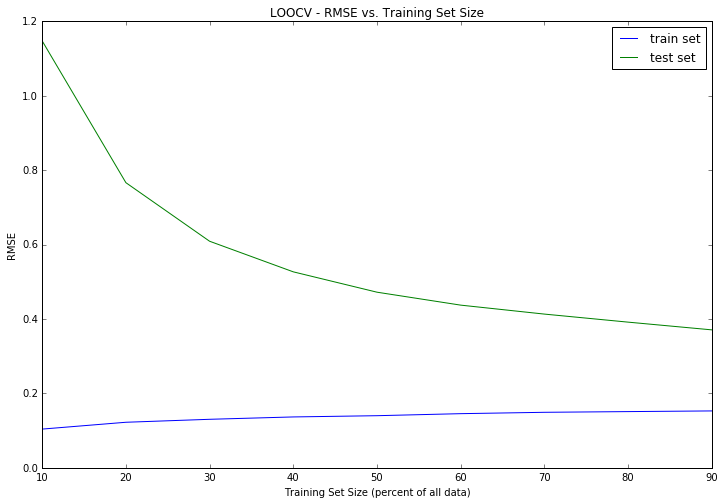

In [13]:
x_values = [10, 20, 30, 40, 50, 60, 70, 80, 90]
plt.figure(figsize = (12,8));
plt.title("LOOCV - RMSE vs. Training Set Size")
plt.ylabel("RMSE")
plt.xlabel("Training Set Size (percent of all data)")
plt.plot(x_values, train_errors, label="train set");
plt.plot(x_values, test_errors, label="test set");
plt.legend();
#plt.savefig("/Users/Alexander/WINE/data/RMSE_vs_Training_Set_Size.png")